In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2.0,
})


In [2]:
test_predictions = pd.read_csv("test_predictions.csv")
test_predictions.head()

,true_energy,pred_log10_energy,pred_energy,residual_log10,event_id
0,108859.773438,3.477310,3001.306885,-1.559557,242
1,14684.890625,4.279639,19038.785156,0.112769,778
2,127.363152,2.308816,203.617905,0.203772,1171
3,2789.717773,3.456718,2862.316895,0.011158,1634
4,3609.210693,2.801775,633.541382,-0.755637,3741


In [3]:
trueE = test_predictions["true_energy"].to_numpy()
predE = test_predictions["pred_energy"].to_numpy()

rel = (predE - trueE) / trueE   # ΔE/E
ratio = predE / trueE           # pred/true

q16_rel, q50_rel, q84_rel = np.quantile(rel, [0.16, 0.50, 0.84])
q16_rat, q50_rat, q84_rat = np.quantile(ratio, [0.16, 0.50, 0.84])

W68_half_rel = 0.5 * (q84_rel - q16_rel)


In [4]:
print("Relative error ΔE/E (central 68% interval):")
print(f"  q16 = {100*q16_rel:+.1f}%   median = {100*q50_rel:+.1f}%   q84 = {100*q84_rel:+.1f}%")
print(f"  W68/2 = {100*W68_half_rel:.1f}% (half-width)")

Relative error ΔE/E (central 68% interval):
  q16 = -56.5%   median = +2.4%   q84 = +102.8%
  W68/2 = 79.6% (half-width)


In [5]:
print("\nRatio pred/true (central 68% interval):")
print(f"  q16 = {q16_rat:.2f}x   median = {q50_rat:.2f}x   q84 = {q84_rat:.2f}x")
print(f"  (median-1) = {100*(q50_rat-1):+.1f}%")


Ratio pred/true (central 68% interval):
  q16 = 0.43x   median = 1.02x   q84 = 2.03x
  (median-1) = +2.4%


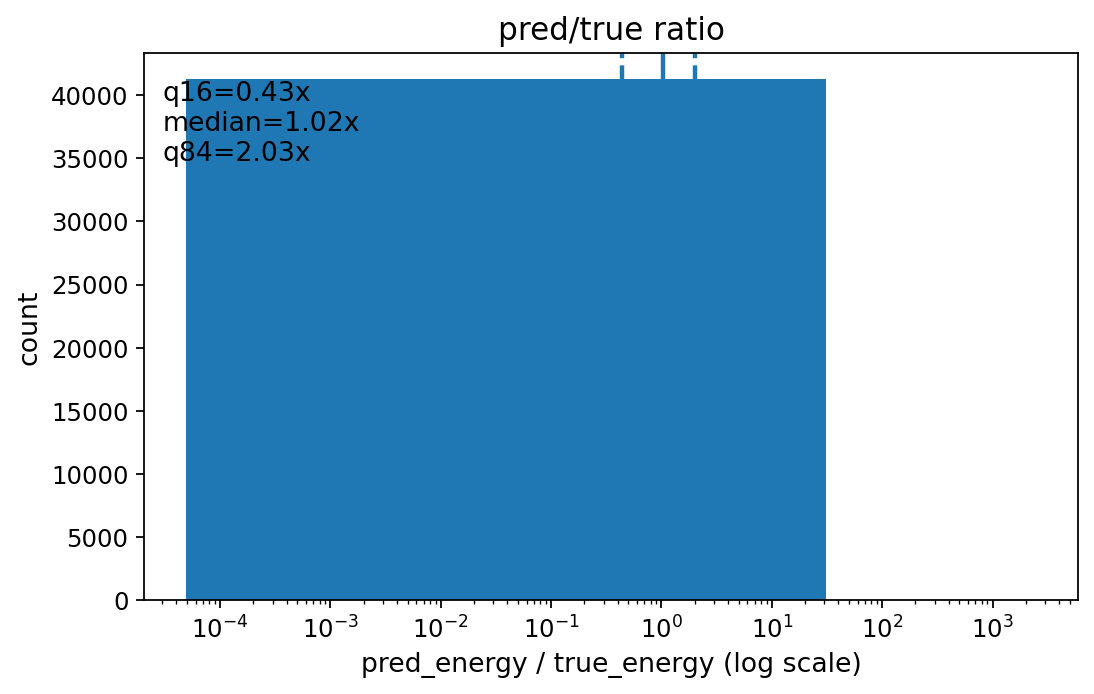

In [6]:
fig, ax = plt.subplots(figsize=(7, 4.5))

ax.hist(ratio, bins=80)
ax.set_xscale("log")

ax.axvline(q16_rat, linestyle="--")
ax.axvline(q50_rat, linewidth=2)
ax.axvline(q84_rat, linestyle="--")

ax.set_title("pred/true ratio")
ax.set_xlabel("pred_energy / true_energy (log scale)")
ax.set_ylabel("count")

ax.text(
    0.02, 0.95,
    f"q16={q16_rat:.2f}x\nmedian={q50_rat:.2f}x\nq84={q84_rat:.2f}x",
    transform=ax.transAxes, va="top"
)

fig.tight_layout()
plt.show()


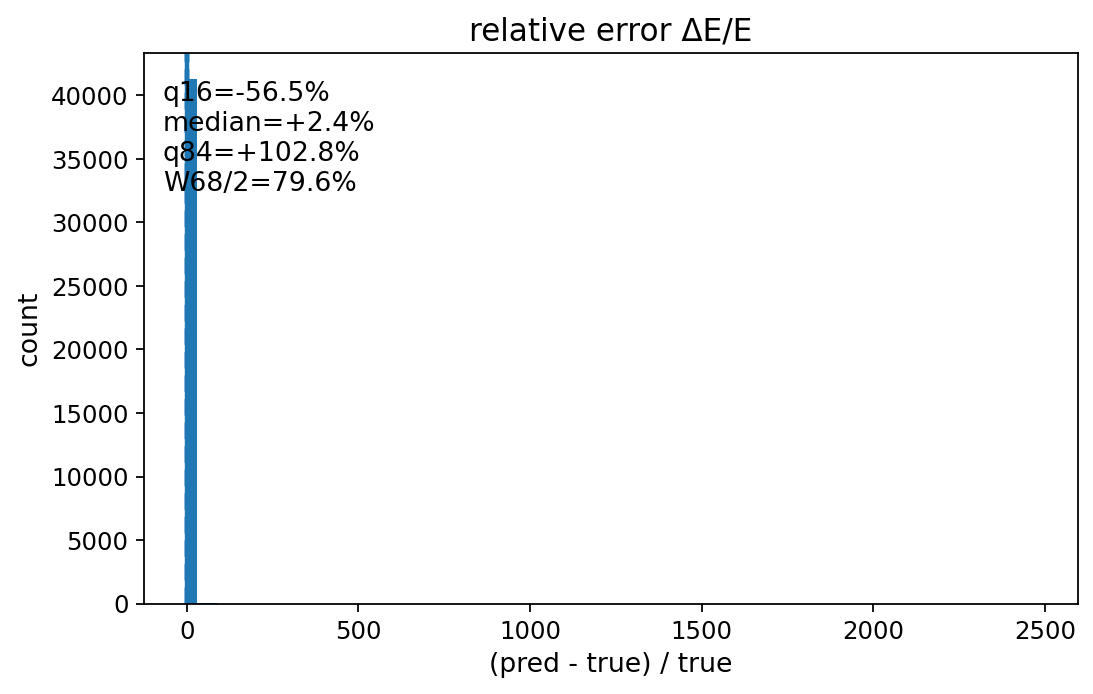

In [7]:
fig, ax = plt.subplots(figsize=(7, 4.5))

ax.hist(rel, bins=80)

ax.axvline(q16_rel, linestyle="--")
ax.axvline(q50_rel, linewidth=2)
ax.axvline(q84_rel, linestyle="--")

ax.set_title("relative error ΔE/E")
ax.set_xlabel("(pred - true) / true")
ax.set_ylabel("count")

ax.text(
    0.02, 0.95,
    f"q16={100*q16_rel:+.1f}%\nmedian={100*q50_rel:+.1f}%\nq84={100*q84_rel:+.1f}%\nW68/2={100*W68_half_rel:.1f}%",
    transform=ax.transAxes, va="top"
)

fig.tight_layout()
plt.show()


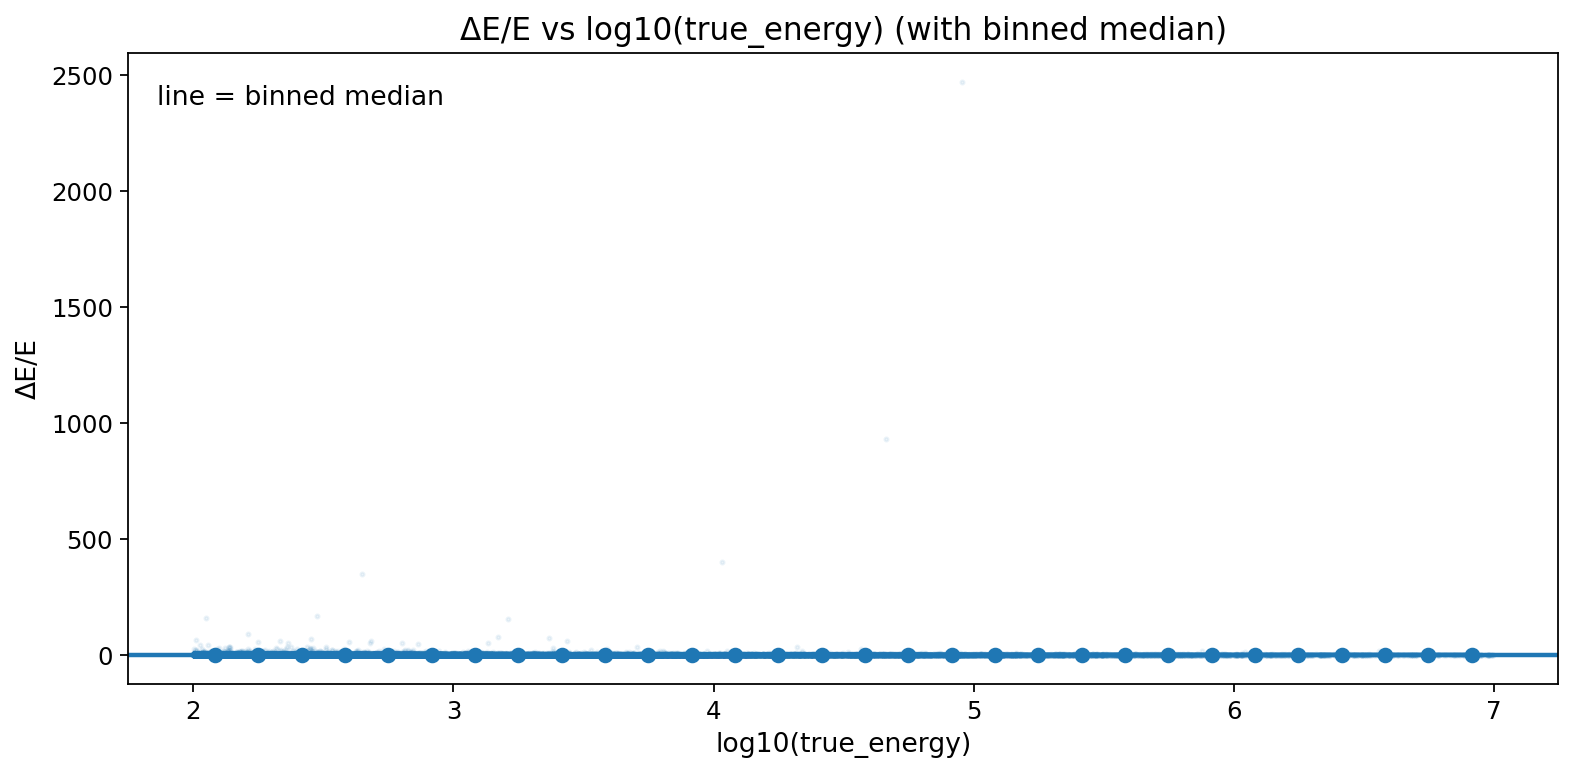

In [8]:
logt = np.log10(trueE)

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(logt, rel, s=3, alpha=0.08)

# binned median
nbins = 30
bins = np.linspace(logt.min(), logt.max(), nbins + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

med = np.full(nbins, np.nan)
for i in range(nbins):
    m = (logt >= bins[i]) & (logt < bins[i + 1])
    if m.any():
        med[i] = np.median(rel[m])

ax.plot(centers, med, marker="o", linewidth=2)

ax.axhline(0)
ax.set_title("ΔE/E vs log10(true_energy) (with binned median)")
ax.set_xlabel("log10(true_energy)")
ax.set_ylabel("ΔE/E")

ax.text(0.02, 0.95, "line = binned median", transform=ax.transAxes, va="top")

fig.tight_layout()
plt.show()


In [9]:
df = test_predictions.copy()

trueE = df["true_energy"].to_numpy()
predE = df["pred_energy"].to_numpy()
reslog = df["residual_log10"].to_numpy()

In [10]:
# --- Metrics ---
rel_err = (predE - trueE) / trueE
ratio = predE / trueE

print("N =", len(df))
print(f"log10 residual: MAE={np.mean(np.abs(reslog)):.4f}  RMSE={np.sqrt(np.mean(reslog**2)):.4f}  Bias={np.mean(reslog):.4f}  Std={np.std(reslog):.4f}")
print(f"relative error: mean(|ΔE|/E)={np.mean(np.abs(rel_err)):.3f}  median(|ΔE|/E)={np.median(np.abs(rel_err)):.3f}")
print(f"ratio pred/true: median={np.median(ratio):.3f}  16-84%=[{np.quantile(ratio,0.16):.3f}, {np.quantile(ratio,0.84):.3f}]")

N = 41311
log10 residual: MAE=0.3075  RMSE=0.4659  Bias=-0.0488  Std=0.4633
relative error: mean(|ΔE|/E)=0.919  median(|ΔE|/E)=0.448
ratio pred/true: median=1.024  16-84%=[0.435, 2.028]


In [11]:
# --- Worst 10 (based on log residual) ---
df["abs_reslog"] = np.abs(df["residual_log10"])
display(df.sort_values("abs_reslog", ascending=False).head(10)[
    ["event_id","true_energy","pred_energy","residual_log10","abs_reslog"]
])


,event_id,true_energy,pred_energy,residual_log10,abs_reslog
27428,345448,8910358.000,441.167725,-4.305292,4.305292
39256,185639,6095022.500,309.379913,-4.294483,4.294483
25096,235608,4745131.500,397.208099,-4.077230,4.077230
21515,34290,8557979.000,959.466187,-3.950341,3.950341
5814,281296,2018725.000,263.624756,-3.884091,3.884091
32357,277571,2553752.250,345.842377,-3.868301,3.868301
38587,319586,1216637.500,228.693161,-3.725908,3.725908
11307,33555,6507332.000,1322.133179,-3.692128,3.692128
21490,21231,1251436.625,297.704498,-3.623623,3.623623
25224,286583,4874876.500,1377.068726,-3.549008,3.549008


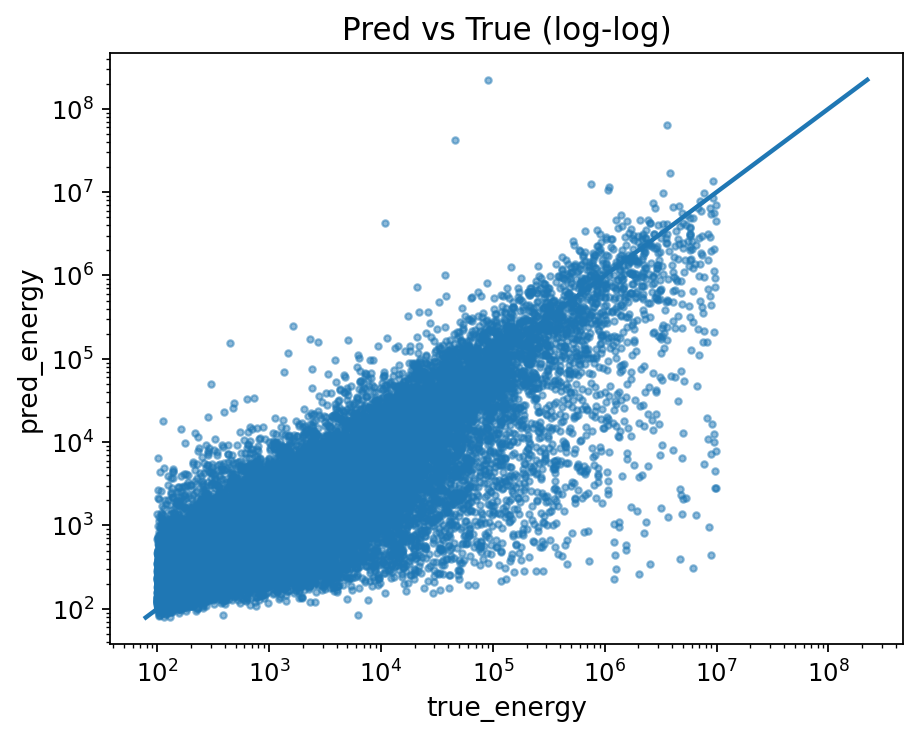

In [12]:
# --- Plot 1: true vs pred (energy) ---
plt.figure()
plt.scatter(trueE, predE, s=8, alpha=0.5)
plt.xscale("log"); plt.yscale("log")
mn = min(trueE.min(), predE.min()); mx = max(trueE.max(), predE.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("true_energy"); plt.ylabel("pred_energy")
plt.title("Pred vs True (log-log)")
plt.show()

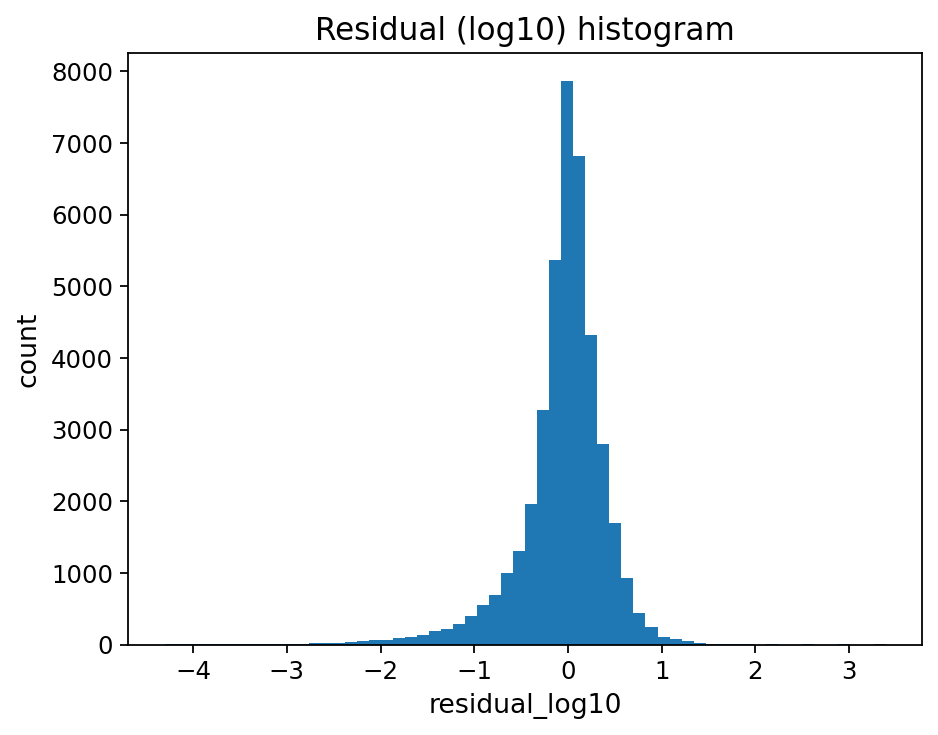

In [13]:
# --- Plot 2: residual_log10 histogram ---
plt.figure()
plt.hist(reslog, bins=60)
plt.xlabel("residual_log10"); plt.ylabel("count")
plt.title("Residual (log10) histogram")
plt.show()


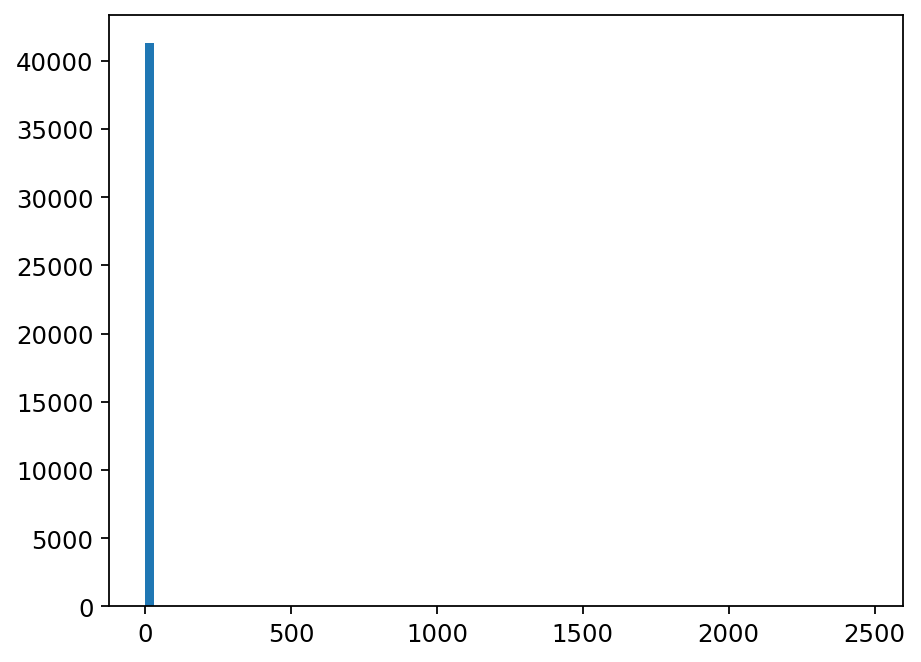

In [14]:
# --- Plot 3: ratio histogram (pred/true) ---
plt.figure()
plt.hist(ratio, bins=80)
plt;

In [15]:
import numpy as np
print("max diff residual check:",
      np.max(np.abs(df["residual_log10"] - (np.log10(df["pred_energy"]) - np.log10(df["true_energy"])))))

print("max diff pred_log10 check:",
      np.max(np.abs(df["pred_log10_energy"] - np.log10(df["pred_energy"]))))


max diff residual check: 2.588437633121998e-07
max diff pred_log10 check: 2.5760372501792972e-08


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- High-quality defaults ----------
plt.rcParams.update({
    "figure.dpi": 160,        # notebook'ta görüntü çözünürlüğü
    "savefig.dpi": 300,       # kaydederken çözünürlük
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2.0,
})

df = test_predictions.copy()

# Hazırlık
df["log10_true"] = np.log10(df["true_energy"])
df["log10_pred"] = np.log10(df["pred_energy"])  # kontrol için; pred_log10_energy ile yakın olmalı
res = df["residual_log10"]  # = log10(pred) - log10(true)



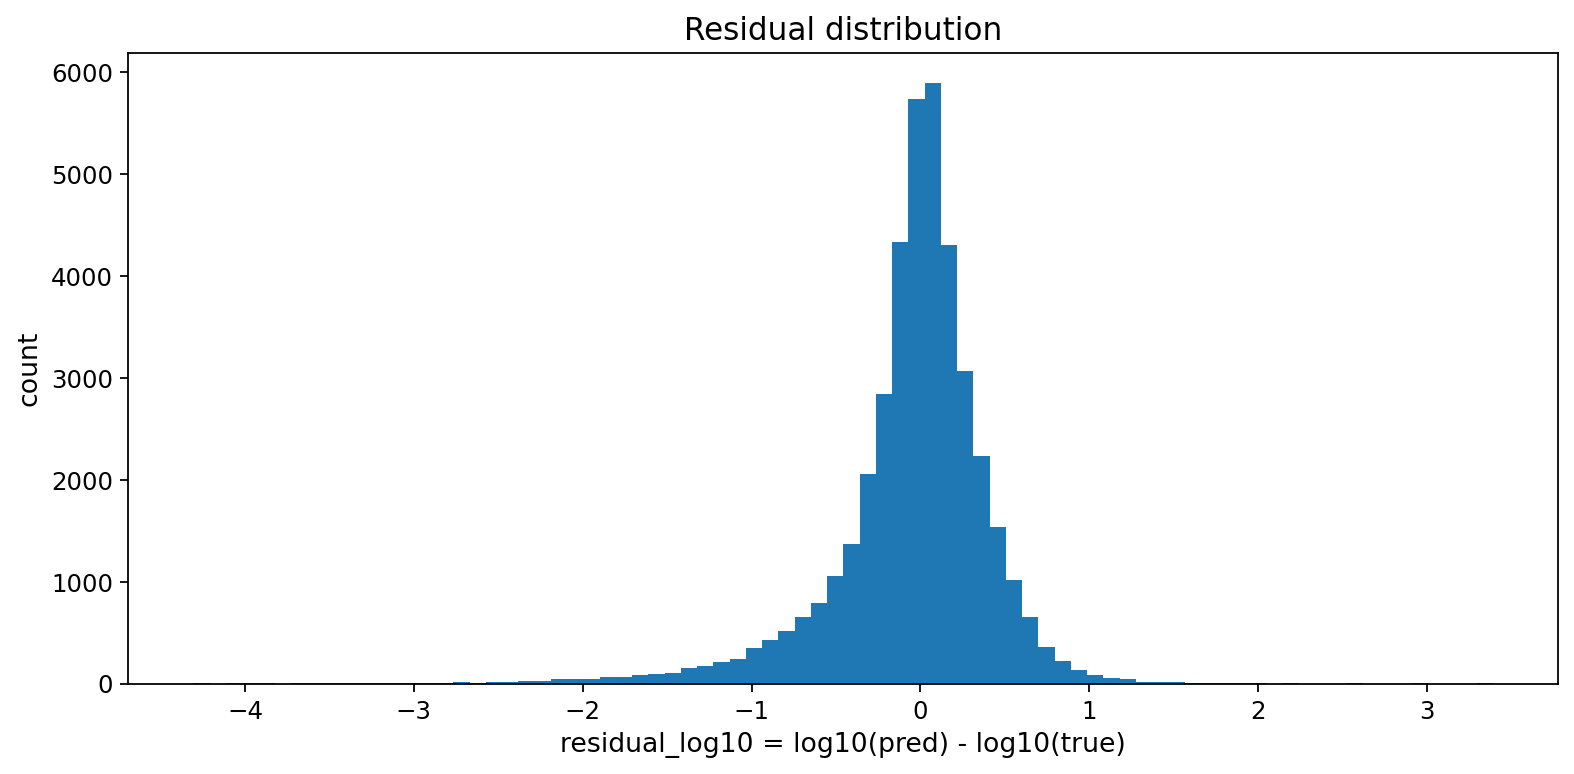

In [17]:
# ---------------------------
# 1) Residual distribution
# ---------------------------
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(res, bins=80)
ax.set_xlabel("residual_log10 = log10(pred) - log10(true)")
ax.set_ylabel("count")
ax.set_title("Residual distribution")
fig.tight_layout()
plt.show()


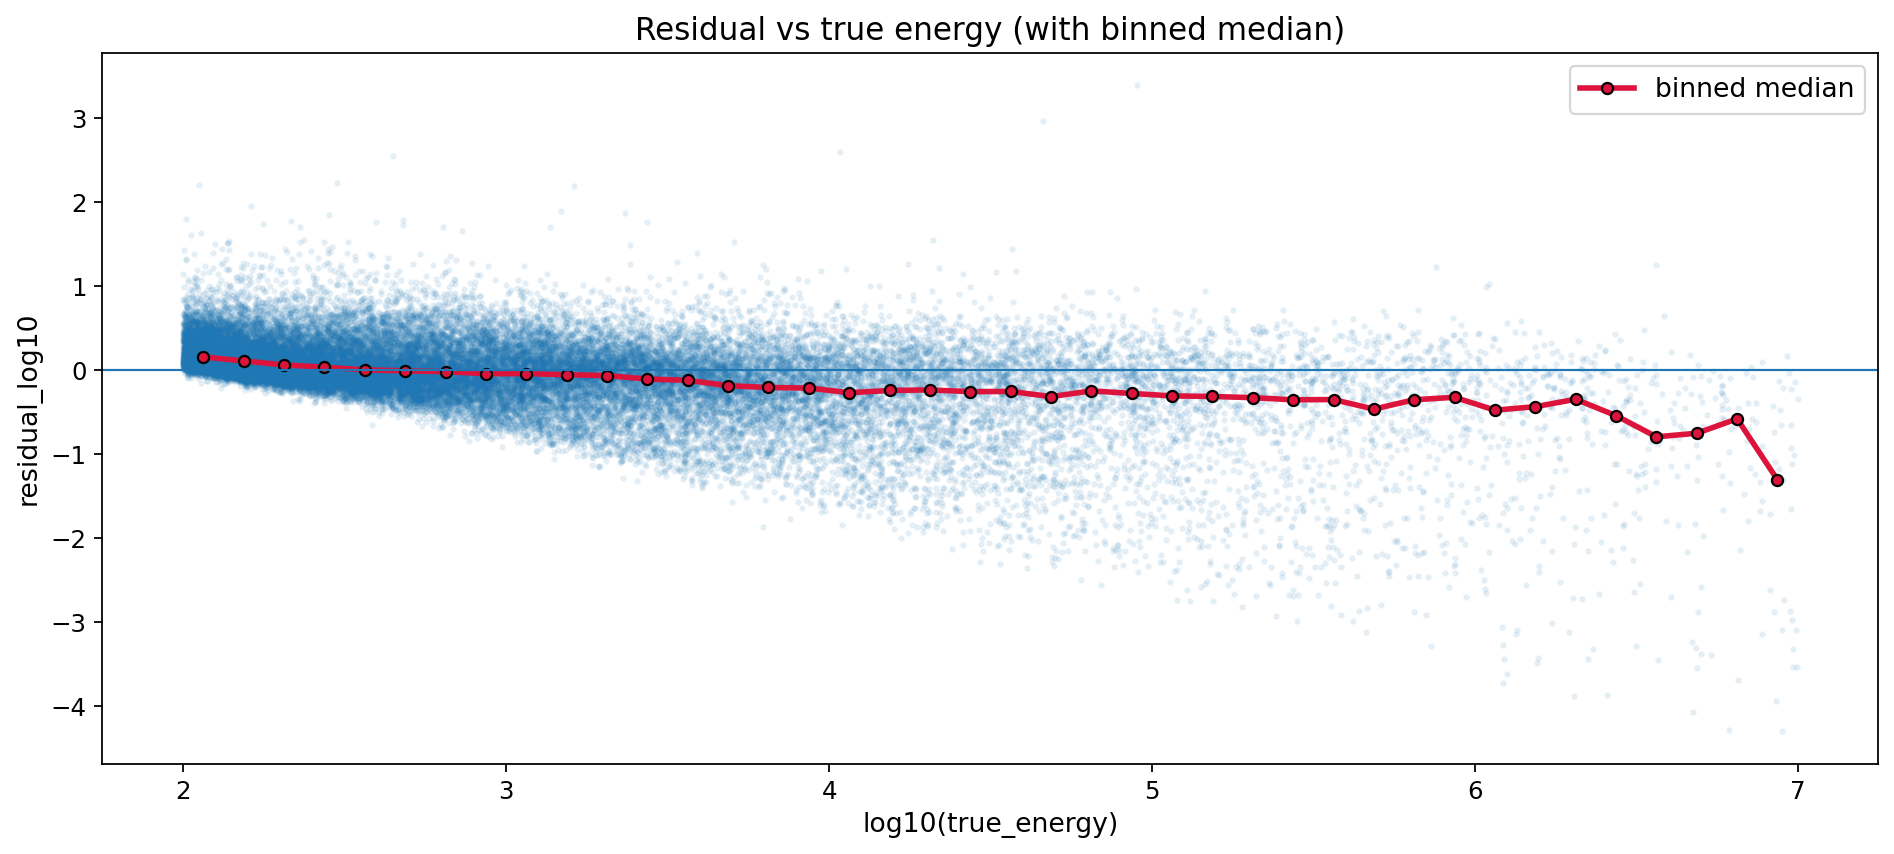

In [18]:
# -------------------------------------------------------
# 2) Residual vs true energy + binned median
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5.5))

ax.scatter(df["log10_true"], res, s=4, alpha=0.08)

nbins = 40
bins = np.linspace(df["log10_true"].min(), df["log10_true"].max(), nbins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

medians = np.full(nbins, np.nan)
for i in range(nbins):
    m = (df["log10_true"] >= bins[i]) & (df["log10_true"] < bins[i + 1])
    if m.any():
        medians[i] = np.median(res[m])

# ✅ binned median çizgisini renklendir
ax.plot(
    bin_centers, medians,
    marker="o",
    linewidth=2.5,
    color="crimson",
    markerfacecolor="crimson",
    markeredgecolor="black",
    markersize=5,
    label="binned median"
)

ax.axhline(0, linewidth=1)

ax.set_xlabel("log10(true_energy)")
ax.set_ylabel("residual_log10")
ax.set_title("Residual vs true energy (with binned median)")
ax.legend()
fig.tight_layout()
plt.show()


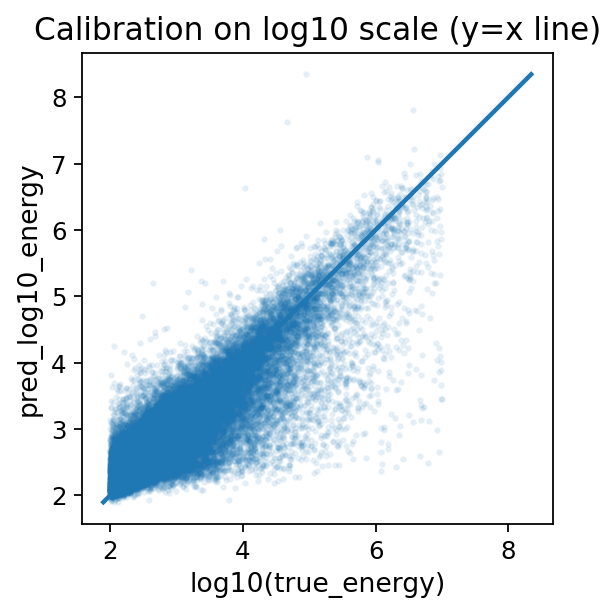

In [19]:

# -----------------------------------------
# 3) Calibration on log10 scale (y=x line)
# -----------------------------------------
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(df["log10_true"], df["pred_log10_energy"], s=4, alpha=0.08)

mn = min(df["log10_true"].min(), df["pred_log10_energy"].min())
mx = max(df["log10_true"].max(), df["pred_log10_energy"].max())
ax.plot([mn, mx], [mn, mx])

ax.set_xlabel("log10(true_energy)")
ax.set_ylabel("pred_log10_energy")
ax.set_title("Calibration on log10 scale (y=x line)")
ax.set_aspect("equal", adjustable="box")  # kare görünüm daha düzgün kalibrasyon hissi verir
fig.tight_layout()
plt.show()
